In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import numpy as np
import pybaseball
import nutpie
import pytensor.tensor as pt
import pymc as pm
import preliz as pz
import arviz as az
import nutpie

# Introducing (Matern family) GPs as a natural extension to hierarchical modeling

GPs are used in machine learning as a predictive model for a whole dataset.  The ability to construct kernels / covariance functions that represent the known structure in the data and their ability to quantify uncertainty make them powerful tools.

GPs also have a role when doing Bayesian modeling in PPLs like PyMC, Stan, or Numpyro.  You might think about using a GP when:
1. You need to regress out a more functional effect.  For example, a spatial or temporal relationship that you want to be able to represent.
2. Forecasting.  Unlike spline or polynomials, GPs can be used to make reasonable and interpretable extrapolations outside the domain of the observed data.
3. **When you have a hierarchical component in your model, but the groups aren't entirely exchangeable.**

Most introductions to GPs either focus on the first two motivations or take the ML viewpoint.  We're going to introduce what GPs are via the third motivation.  Hopefully this will serve as an intuitive to introduction to GPs, and also a way to show how to overcome various challenges and pitfalls that arise when using GPs in practice.  Throughout we'll use simulated data to illustrate particular points, but we'll return a few times to an example from baseball that uses real data.

# Exchangablilty in hierarchical models

Imagine trying to model the batting average of baseball players using a data set like this one.  Here's the first several rows:

In [5]:
df = pd.read_csv("data/batting_2023.csv")
df.head(10)[["Name", "Tm", "Age", "AB", "H", "BA", "SLG"]]

,Name,Tm,Age,AB,H,BA,SLG
0,CJ Abrams,Washington,22,559,138,0.247,0.415
1,Jos\xc3\xa9 Abreu,Houston,36,533,126,0.236,0.385
2,Wilyer Abreu,Boston,24,76,24,0.316,0.474
3,Ronald Acu\xc3\xb1a Jr.,Atlanta,25,637,215,0.338,0.598
4,Willy Adames,Milwaukee,27,550,119,0.216,0.407
5,Jordyn Adams,Los Angeles,23,39,5,0.128,0.128
6,Riley Adams,Washington,27,143,39,0.273,0.476
7,Jo Adell,Los Angeles,24,58,12,0.207,0.448
8,Ehire Adrianza,Atlanta,33,10,0,0.000,0.000
9,Jes\xc3\xbas Aguilar,Oakland,33,101,23,0.228,0.396


With the goal to estimate the batting average of each player, we can use a hierarchical model with a Binomial likelihood.  This is pretty much identical to [this PyMC example](https://www.pymc.io/projects/examples/en/latest/case_studies/hierarchical_partial_pooling.html).  We'll simplify things a little bit for the sake of illustration and use a Binomial likelihood to model the ratio of Hits to At-bats. 

In this model, we treat every player as **exchangeable**.  Each player will have their own batting average estimated.  It doesn't matter if we shuffle the order, remove players or add players, the results are the same.  Players that had few at-bats, like Jordyn Adams, will have their estimates pulled toward the average of all players.  The assumption underyling this hierarchical model is that while Jordyn has perhaps underperformed or had an injury -- they're playing in the majors and with more opportunities his performance is likely to regress to the mean of the other players.  

In [178]:
ix_player, player = pd.factorize(df.Name, sort=True)

coords = {
    "player": player,
}

with pm.Model(coords=coords) as model:
    intercept = pm.Normal("intercept", mu=0.0, sigma=2.0)
    
    sigma_player = pm.Exponential("sigma_player", scale=1.0)
    player_effect = pm.Normal("player_effect", mu=intercept, sigma=sigma_player, dims="player")
    
    logit_p = player_effect[ix_player]
    pm.Binomial("hits", logit_p=logit_p, n=df.AB.values, observed=df.H.values)

    pm.Deterministic("player_ba", pm.math.sigmoid(player_effect), dims="player")

In [179]:
idata = nutpie.sample(
    nutpie.compile_pymc_model(model, backend="numba"),
    target_accept=0.8,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.31,15
,1300,0,0.31,15
,1300,0,0.31,15
,1300,0,0.31,15
,1300,0,0.32,15
,1300,0,0.31,15


In [170]:
az.summary(idata, var_names=["intercept", "sigma_player", "player_ba"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-1.133,0.008,-1.149,-1.118,0.0,0.0,1861.0,3116.0,1.00
sigma_player,0.115,0.009,0.099,0.132,0.0,0.0,595.0,1142.0,1.02
player_ba[AJ Pollock],0.225,0.018,0.193,0.259,0.0,0.0,9457.0,3490.0,1.00
player_ba[Aaron Hicks],0.247,0.017,0.215,0.279,0.0,0.0,12958.0,4364.0,1.00
player_ba[Aaron Judge],0.254,0.016,0.223,0.283,0.0,0.0,12016.0,4313.0,1.00
...,...,...,...,...,...,...,...,...,...
player_ba[Zach Remillard],0.246,0.019,0.212,0.281,0.0,0.0,10922.0,3884.0,1.00
player_ba[Zack Collins],0.247,0.021,0.207,0.284,0.0,0.0,10926.0,4158.0,1.00
player_ba[Zack Gelof],0.253,0.017,0.222,0.285,0.0,0.0,10238.0,4132.0,1.00
player_ba[Zack Short],0.230,0.017,0.199,0.261,0.0,0.0,9172.0,4323.0,1.00


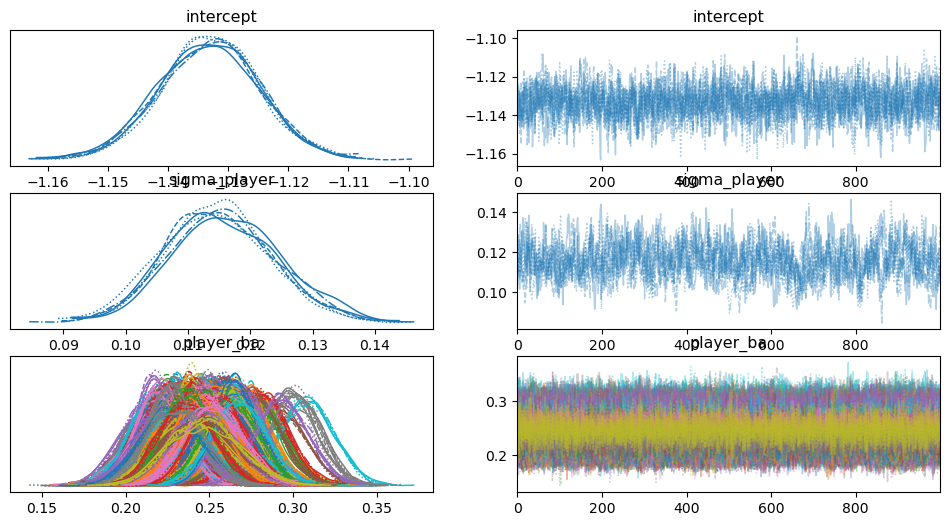

In [171]:
az.plot_trace(idata, var_names=["intercept", "sigma_player", "player_ba"]);

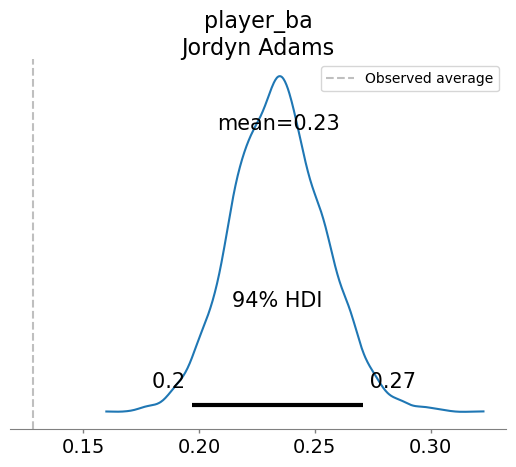

In [172]:
ax = az.plot_posterior(idata, var_names=["player_ba"], coords={"player": ["Jordyn Adams"]});
ax.axvline(x=0.128, color="k", alpha=0.25, linestyle="--", label="Observed average");
ax.legend();

Since the players are exchangeable, the partial pooling that affects Jordyn Adams' batting average comes equally from every other player.

# What if players aren't exchangeable?

Often, the more we learn about our data, the less likely exchangeablity is going to hold.  For example, there's another factor we could incorparate, the `Age` of the player.  What if we think that our hierarchical model of player should be more likely to partially pool information over players that have more similar ages?  **We can use a Gaussian process to accomplish this.**

To see how we can get there, let's rewrite our model but use a multivariate normal with a diagonal covariance matrix, instead of a vector of IID normals.

In [188]:
ix_player, player = pd.factorize(df.Name, sort=True)

coords = {
    "player": player,
}

with pm.Model(coords=coords) as model:
    intercept = pm.Normal("intercept", mu=0.0, sigma=2.0)
    
    sigma_player = pm.Exponential("sigma_player", scale=1.0)
    player_effect = pm.MvNormal("player_effect", mu=intercept, chol=pt.sqrt(sigma_player) * pt.eye(len(player)))
    
    logit_p = player_effect[ix_player]
    pm.Binomial("hits", logit_p=logit_p, n=df.AB.values, observed=df.H.values)

    pm.Deterministic("player_ba", pm.math.sigmoid(player_effect), dims="player")

In [189]:
idata = nutpie.sample(
    nutpie.compile_pymc_model(model, backend="jax"),
    target_accept=0.8,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.32,15
,1300,0,0.31,15
,1300,0,0.31,15
,1300,0,0.30,15
,1300,0,0.30,15
,1300,0,0.30,15


This is the exact same model we had before, except it's parameterized using a multivariate normal with a diagonal covariance matrix.  Even though it samples quite a bit slower, we did this to make it explicit that there's no covariances between players _induced by our prior_.  If there were, we'd have off-diagonal elements that weren't zero.  

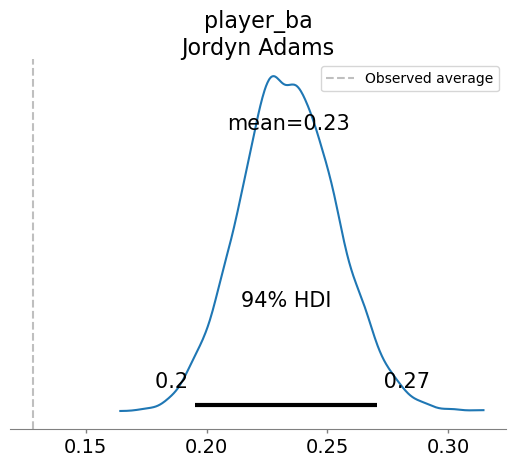

In [191]:
ax = az.plot_posterior(idata, var_names=["player_ba"], coords={"player": ["Jordyn Adams"]});
ax.axvline(x=0.128, color="k", alpha=0.25, linestyle="--", label="Observed average");
ax.legend();

How would we build a prior that incorprates the players age then?  Instead of using a fixed, diagonal covariance matrix, we can use a covariance _function_, or kernel.  It should take two different `age`s as an input, and return a larger value (covariance) if the ages are similar, and a small value if they are pretty different.  The "exponentiated quadratic" is one such covariance that has a particularly simple form:
$$
k(x, x') = \eta^2 \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right] \,,
$$
where $x$ is age.  There are two unknown parameters, $\eta$ and $\ell$.  $\eta$ plays the exact same role as $\sigma$ does in our normal hierarchical model.  It scales the overall size of the effect, which is the total amount of partial pooling.  The parameter $\ell$ is brand new.  It's called the _lengthscale_.  It determines what we mean by "close", when we say one age is close to another.  

In our baseball example, age is measured in years, so close might be $\ell = 1$ year.  If $\ell = 10$, that means that "10" is more the scale that we think ages are similar.  Note that we should be able to set a pretty informative prior on the lengthscale.  Clearly $\ell=0.1$ is too small.  Players batting average is not likely to change significantly if they get one month older.  Also, $\ell = 100$ is unlikely since that's more on the overall scale of a humans lifespan, not just their baseball skills.  Since the lengthscale is so interpretable we'll often be able to set fairly informative priors.


## An example

Here's what the covariance matrix looks like if we have an x that represents ages, and a lengthscale equal to 1.5, which is a value that's on the same scale as people's ages.

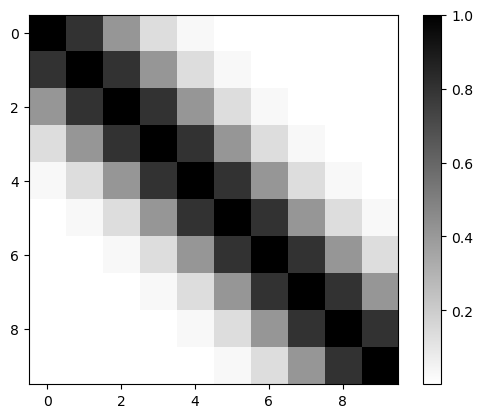

In [17]:
x = np.arange(20, 30)
eta = 1.0
lengthscale = 1.5
cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
K = cov_func(x[:, None]).eval()

plt.imshow(K, cmap="gray_r"); plt.colorbar();

When we order our $x$ sequentially, we see a nice band pattern in the resulting covariance matrix.  The band pattern comes from the fact that our covariance function is giving pairs of ages that are nearby a high covariance. Each cell in the matrix is comparing one age to another, so every combination of pairs is calculated.  **A high covariance value means that if that pair of $x$'s are similar, that means that the values of the GP will be similar there too.**

# So, what is a GP?

Now that we have our covariance function, we can define our GP $f$ as:
$$
f \sim \mathcal{GP}\left( 0 \,, k(x, x') \right)
$$
It's like a multivariate normal, except that the covariance isn't a _matrix_.  It's a _function_.  That means that the overall size or dimension of the multivariate normal is subject to what we decide to plug into that function.  For example, if we have three players with three different ages: 24, 25, and 26 and we plug those in, we get a 3 dimensional multiviariate normal with a $3 \times 3$ covariance matrix.  If we plug in 10 players, it'll be 10 dimensional.  If we plug in 100, it'll be 100 dimensional, and so on. 

**At a basic level, that's really all there is to it.**  If you've tried to learn about GPs before, you'll know that things get more complicated.  This happens down two directions:
1. The covariance function.  We can represent very interesting structures using the covariance function, from random walks to complex periodic behavior, covariances that match up with neural networks, and any aggregation or combinations of these (and many more).
2. Computation. Naively implemented, **GPs are slow**.  They scale $\mathcal{O}(n^3)$, where $n$ is the dimension of the multivariate normal you need to compute the probabilities of.  There are lots of different approximations and computational tricks to improve this scaling.  A lot of GP research focuses here. 

At the end of the day though, a GP is a GP is a GP.  However, there are different kernels, approximations, and methods to accellerate computation.

# Taking a step back

Before we dive into baseball modeling, it's important to take a step back and use some simulated data to start thinking about limiting cases.  Understanding these is critical to debugging GPs when modeling goes wrong.  Very often, for me and for others I've worked with, you'll fit fit a GP model and immediately something will go wrong and it wont sample properly.  It's pretty much inevitable.  If it's not way to slow, then maybe the chains didn't converge or there were diverging samples.  Or, the results were just too unexpected to be believeable.  I think this causes GPs to unfairly get a bad rap, or lead to dissappointment.  In most other resources, the theory behind GPs is explained, then maybe a working example is given, but after that you're on your own. 

My goal in this presentation is give a bit of help on how to diagnose and fix issues -- from the perspective of someone whos fit many broken GP models. 

# Limiting cases

The starting place is limiting cases.  Let's look at a one dimensional (think time series, batter age) GP with our simple exponentiated quadratic coviance function.  

## Case 1: The lengthscale $\ell \rightarrow 0$

When the lengthscale goes to zero, the covariance function reduces to the delta function:
$$
\begin{align}
\lim_{\ell\to0} k(x, x') &= \eta^2 \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right] \\
                         &= \eta^2 \mathrm{exp}\left[-\frac{1}{2} \left(\frac{x - x'}{\ell}\right)^2 \right] \\
                         &= \begin{cases}
                               \eta^2 & \text{if } x = x' \\
                               0 & \text{otherwise} \,.
                            \end{cases} \\
\end{align}
$$
Which you might recognize produces the identity matrix.  This comes out to be exactly the same as when we using the multivariate normal in the the batting average example.  We can also show in code where you can see it turns out to be the identity matrix.

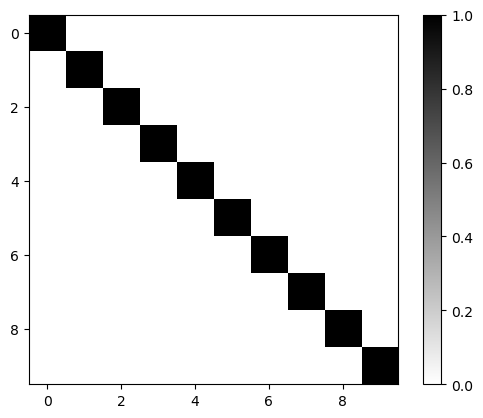

In [59]:
x = np.arange(10)
eta = 1.0
lengthscale = 0.000001 # lengthscale is small relative to the spacing of the x's
cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=lengthscale)
K = cov_func(x[:, None]).eval()

plt.imshow(K, cmap="gray_r"); plt.colorbar();

There are two important points here:

1. **The reason this is important for modeling is because when the lengthscale is small, the GP is _equivalent_ to a normal hierarchical model.**
2. **If the lengthscale is smaller than the resolution of your data, then you won't be able to detect the differences there.** For example, it's impossible to detect daily relationships in baseball players age effect, if the age in the data is specified as a year only.

In particular, point 2 can produce an identifiability issue, which will slow sampling and make it less likely that the MCMC chains will converge.  We can see this in the sketch below:

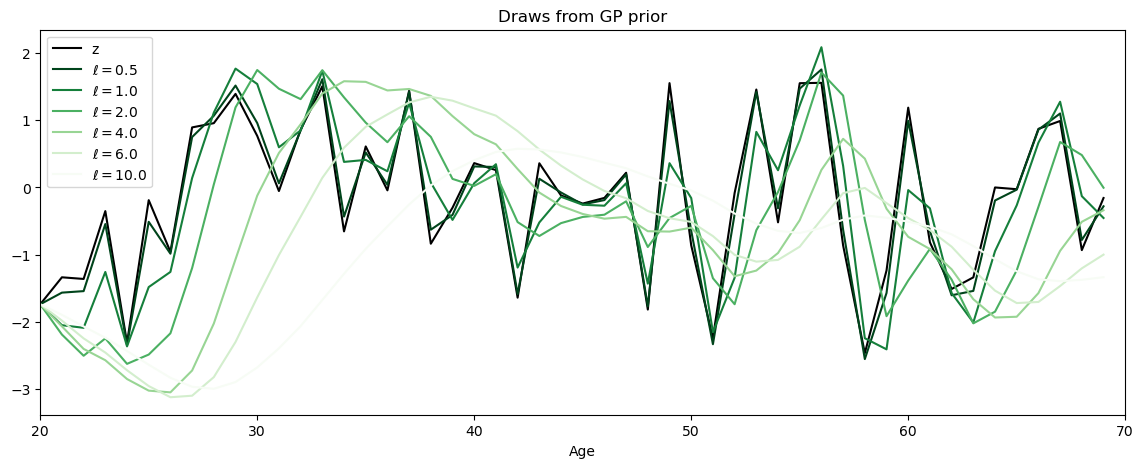

In [86]:
RANDOM_SEED = 8
rng = np.random.default_rng(RANDOM_SEED)

n = 50 # number of days of ages
x = np.arange(20, 20 + n)

lengthscales = [0.5, 1.0, 2.0, 4.0, 6.0, 10.0]
colors = np.linspace(0, 1, len(lengthscales))

fig, ax = plt.subplots(1, 1, figsize=(14, 5))

# draw a sample of random noise
z = rng.normal(size=n)

m = ax.plot(x, z, color="k", label="z");

for i, ell in enumerate(lengthscales):
    cov = pm.gp.cov.Matern52(input_dim=1, ls=ell)
    K = cov(x[:, None]).eval()
    L = np.linalg.cholesky(K + 1e-6 * np.eye(n))
    
    f = L @ z
    
    ax.plot(x, f, color=plt.cm.Greens_r(colors[i]), label=f"$\ell={ell}$")

ax.legend(loc="upper left");
ax.set_xlim([20, n + 20]);
ax.set_xlabel("Age");
ax.set_title("Draws from GP prior");

This shows how a random IID sample of normal noise can be "smoothed" by a GP at varying lengthscales.  We can see that it hardly changes when the lengthscale drops below the resolution of the data.

## The fix

We need our lengthscale prior to block small lengthscales, particularly those below the resolution of the data.  As we've seen, a small lenthscale GP and a normal hierarchical term together in model would be unidentifiable.  

Examples of informative priors that limit the amount of mass at small lengthscales are the inverse gamma distribution, the inverse of an exponential distribution, the log-normal, and the penalized complexity (PC) prior.  Samples from these three distributions are shown below:

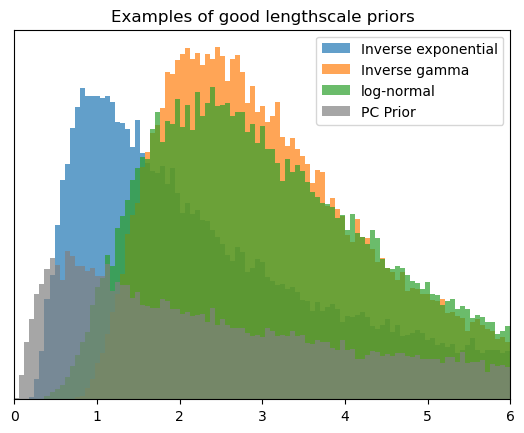

In [87]:
# draw samples from PC prior
alpha_ell, lower_ell = 0.1, 1.0
lam_ell = -np.log(alpha_ell) * np.sqrt(lower_ell)
alpha = 0.5
beta = 1.0 / (lam_ell ** 2)
ell_inv = pm.Weibull.dist(alpha=alpha, beta=beta)
ell = 1 / ell_inv
ell_pc_samples = pm.draw(ell, 50_000)

# inverse gamma
ell = pz.maxent(
    pz.InverseGamma(),
    lower=0.5,
    upper=8.0,
    mass=0.95,
    plot=False,
)
ell = pm.InverseGamma.dist(alpha=ell.alpha, beta=ell.beta)
ell_ig_samples = pm.draw(ell, 50_000)

# lognormal
ell = pz.maxent(
    pz.LogNormal(),
    lower=0.5,
    upper=8.0,
    mass=0.95,
    plot=False,
)
ell = pm.Lognormal.dist(mu=ell.mu, sigma=ell.sigma)
ell_ln_samples = pm.draw(ell, 50_000)

# inverse exponential
ell_inv = pm.Exponential.dist(scale=0.5)
ell = 1 / ell_inv
ell_ie_samples = pm.draw(ell, 50_000)


bins = np.linspace(0, 6, 100)
plt.hist(ell_ie_samples, bins=bins, label="Inverse exponential", alpha=0.7);
plt.hist(ell_ig_samples, bins=bins, label="Inverse gamma", alpha=0.7);
plt.hist(ell_ln_samples, bins=bins, label="log-normal", alpha=0.7);
plt.hist(ell_pc_samples, bins=bins, label="PC Prior", alpha=0.7, color="gray");
plt.xlim([0, 6]);
plt.yticks([])
plt.title("Examples of good lengthscale priors");
plt.legend();

As for what the PC prior _is_, you can read more about it [here](https://arxiv.org/abs/1403.4630), [here](https://arxiv.org/abs/1503.00256) and [here](https://dansblog.netlify.app/posts/2022-08-29-priors4/priors4.html).  The inverse gamma prior recommendation comes from [here](https://betanalpha.github.io/assets/case_studies/gp_part1/part1.html). 

## Case 2: The lengthscale $\ell \rightarrow \infty$

When the lengthscale goes to infitity, the covariance function reduces to a matrix whose entries are all constants:
$$
\begin{align}
\lim_{\ell\to\infty} k(x, x') &= \eta^2 \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right] \\
                         &= \eta^2 
\end{align}
$$
This is just a matrix where every entry equals $\eta^2$.  This likely looks a litte strange to you, but, it is possible to draw prior samples from this GP:

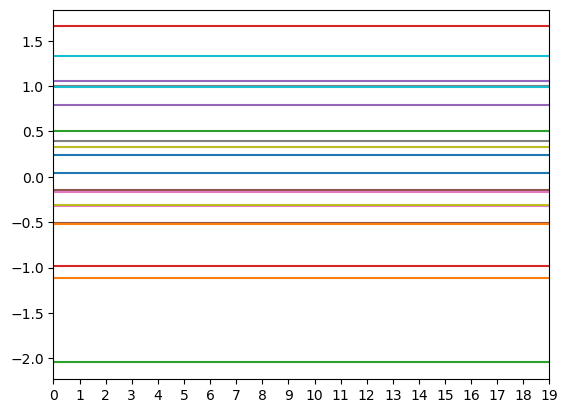

In [94]:
n = 20
s = pm.draw(pm.MvNormal.dist(mu=np.zeros(n), cov=np.ones((n, n))), 20).T
plt.plot(s);
plt.xlim([0, 19]);
plt.xticks(np.arange(20));

**Every sample drawn from this GP is a flat line of varying height.**  This is the same thing as the intercept, which is a term your model probably already has in it.  This means that we potentially hit another identifiability issue again, this time when the lengthscale becomes large.  You can see this in action in the sketch below.  When the lengthscale starts getting into the hundreds, the smoothing looks really flat, and once it's flat it doesn't change.

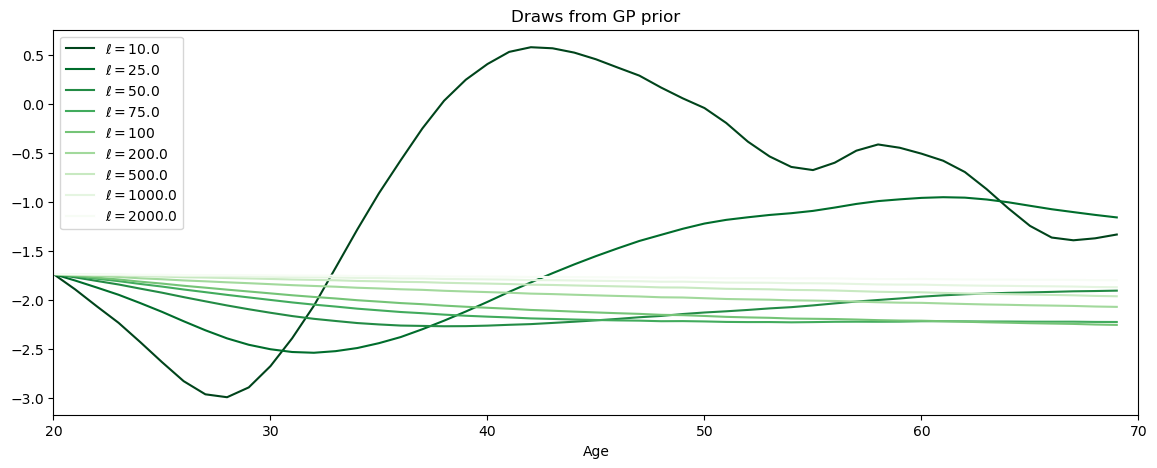

In [98]:
RANDOM_SEED = 8
rng = np.random.default_rng(RANDOM_SEED)

n = 50 # number of days of ages
x = np.arange(20, 20 + n)

lengthscales = [10.0, 25.0, 50.0, 75.0, 100, 200.0, 500.0, 1000.0, 2000.0]
colors = np.linspace(0, 1, len(lengthscales))

fig, ax = plt.subplots(1, 1, figsize=(14, 5))

# draw a sample of random noise
z = rng.normal(size=n)

for i, ell in enumerate(lengthscales):
    cov = pm.gp.cov.Matern52(input_dim=1, ls=ell)
    K = cov(x[:, None]).eval()
    L = np.linalg.cholesky(K + 1e-6 * np.eye(n))
    
    f = L @ z
    
    ax.plot(x, f, color=plt.cm.Greens_r(colors[i]), label=f"$\ell={ell}$")

ax.legend(loc="upper left");
ax.set_xlim([20, n + 20]);
ax.set_xlabel("Age");
ax.set_title("Draws from GP prior");

## The fix

The fix this time is to again, be aware that this is possible.  You could consider:
1. Remove the intercept term from your model.
2. Remove the GP from your model, because if it's trying to be flat, then it's not measuring an effect.
 
In fact, all GPs (of this type with a lengthscale parameter, the Matern family) aren't fixed to have a mean exactly at zero, so there's always a little bit of an identifiability problem with the intercept.  The identifiability problem gets worse as the lengthscale increases.  If you're in a middle ground and it's causing issues, you can additionally consider:

3. Constraining the GP to have mean of zero. How exactly you do that depends on the type of GP you're dealing with.

Finally:

4. Depending on your context it may make sense to address this problem by constraining the lengthscale to not be too large.  The inverse gamma is particularly good for this.  This is OK to do when you're **sure** that there is a GP in your model and your goal isn't to test whether an effect from the GP is there or not.  If you're trying to test whether there is an effect or whether it's "flat", use the PC prior because that's what it was designed for.

# The takeaway? Use informative priors to help with identifiability issues.

Noticing a pattern here?  The more informative you can make your lengthscale prior, the better.  Especially when you're able to rule out extreme values for lengthscales.  It's difficult anyway to design a non-informative prior for a GP, that actually works well.  I think it's rather pointless anyway, because what value is an uninformative prior here?  Even with the choice of kernel, a GP is already an extremely flexible functional form.  The lengthscale is a continuous parameter that controls model complexity.  It's like if the number of spline knots or the polynomial order were a continuous parameter that you could sample over.  

Use MCMC to average over all reasonable lengthscale values, because it's usually quite difficult to recover the "true" lengthscale, even with simulated examples.  One underlying reason this is true can be seeb by looking at the _power spectral density_ of the kernel.  It may feel like we're getting pretty far away from practical issues here, but please bear with me!  It does matter in practice.  There's yet another identifiability issue between the lengthscale $\ell$ and the scale, $\eta$.  This one is inherent to the form of the Matern family of covariance functions.  You can plainly see it when you look at the Fourier transform of the exponentiated quadratic covariance function (via Bochner's theorem).  The result is given below:
$$
\begin{align}
S(s) \propto \eta^2 \ell \exp{\left[ -2\pi\ell^2s^2 \right]}
\end{align}
$$
Here, $S(s)$ is the power spectrum at frequencies $s$ of the kernel.  In the first part, $\eta^2$ and $\ell$ are multiplying each other.  This means that their product is identified, but $\eta$ and $\ell$ individually aren't.  Even though we're in Fourier space, this problem will exist in the non-Fourier space.  Fortunately inside the exponential function we just have the lengthscale parameter.  We can consider $\eta$ and $\ell$ _weakly_ identifiable.  You can read more about it in this note [here](https://drive.google.com/file/d/0B3WHb3BabixAYlptTVBWUGdyVEE/view?resourcekey=0-mj7f4AZQ-UN1Rvd9NrRlHg).  

In practice what you'll find is that even with fairly narrow posterior on the GP itself, you'll see fairly wide posterior distributions on _both_ $\eta$ and $\ell$, and this is mostly why.  

## For GP's, what is "N"

The other reason has to do with what "N" is.  In Bayesian modeling, or statistics generally, the more data you collect, the lower your uncertainty will tend to be.  This doesn't necessarily hold for GPs.  To obtain a narrow posterior around the lengthscale parameter, there needs to be some number of times that it crosses zero.  You can think of a large lengthscale as representing the fact that you haven't seen many (or any) zero crossings or repetitions of the GP.  Larger lengthscales, along with their identifiability issues that we discussed, will also tend to have broader posteriors.  This is sketched below:

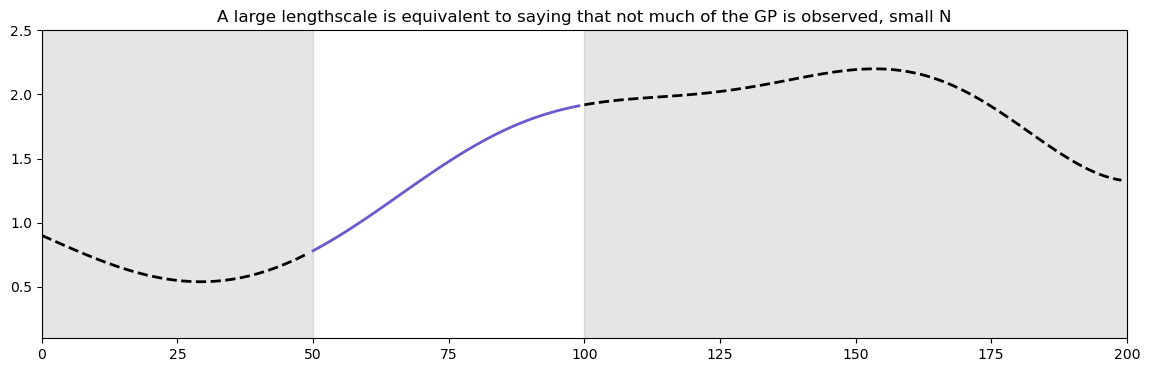

In [115]:
RANDOM_SEED = 8
rng = np.random.default_rng(RANDOM_SEED)

x = np.arange(200)

eta = 3.0
cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=50)
f = pm.draw(pm.MvNormal.dist(mu=np.zeros(len(x)), cov=cov(x[:, None])), random_seed=rng)

fig = plt.figure(figsize=(14, 4))
plt.plot(x[0:50], f[0:50], color="k", lw=2, linestyle="--");
plt.plot(x[50:100], f[50:100], color="slateblue", lw=2);
plt.plot(x[100:], f[100:], color="k", lw=2, linestyle="--");
plt.fill_between([0, 50], [0.0, 0.0], [3.0, 3.0], alpha=0.1, color="k");
plt.fill_between([100, 200], [0.0, 0.0], [3.0, 3.0], alpha=0.1, color="k");
plt.xlim([0, 200]);
plt.ylim([0.1, 2.5]);
plt.title("A large lengthscale is equivalent to saying that not much of the GP is observed, small N");

Since you've technically not observed much data, your lengthscale posterior will likely be wide.  

# Back to baseball

Apparently, batting average and age don't have too much in common.  There's another quantity called SLG (slugging percentage).  It's defined as the total number of bases obtained per at bat, so proportionally extra weight is given to home runs, triples and doubles.  HRs count for 4 and singles count for 1.  To model SLG, we use a count likelihood over the total number of bases, either Poisson or Negative Binomial are common choices.  Then we include the number of at bats as an offset term to get an estimate of the SLG. Here's a look at the data:

In [334]:
cols = ["Season", "Name", "Team", "Age", "AB", "slg", "bases"]

df = pd.read_csv("data/slg_10years.csv")[cols]
df["bases"] = df["bases"].astype(int)
df = df[df.Team != "- - -"]

df[df.Name.str.contains("Judge|Trout|Ohtani")][cols].sort_values(["Name", "Season"])

,Season,Name,Team,Age,AB,slg,bases
4906,2016,Aaron Judge,NYY,24,84,0.345238,29
9,2017,Aaron Judge,NYY,25,542,0.627306,340
190,2018,Aaron Judge,NYY,26,413,0.527845,218
352,2019,Aaron Judge,NYY,27,378,0.539683,204
2306,2020,Aaron Judge,NYY,28,101,0.554455,56
140,2021,Aaron Judge,NYY,29,550,0.543636,299
1,2022,Aaron Judge,NYY,30,570,0.685965,391
237,2023,Aaron Judge,NYY,31,367,0.613079,225
0,2024,Aaron Judge,NYY,32,559,0.701252,392
13,2014,Mike Trout,LAA,22,602,0.561462,338


Then, we'll write down an outline of the model, with every factor we want to include and how we should include it:

- **Player**: A players skill level is the largest factor in SLG.  After all, it's really what this statistic is trying to measure.  We use a `ZeroSumNormal` here since we aren't interested in extrapolating to new players.  
- **Park**: Different baseball fields have different sizes and shapes.  The park shape isn't standardized, unlike football, soccer or basketball.  That mean's there's probably going to be an effect based on what team a player is on, because they play at home for half their games.  It's going to be easier to hit home runs in smaller parks.  We use a `ZeroSumNormal` here, because we aren't interested in extrapolating the effects to new teams or new baseball fields.   This is the same as a non-centered normal with an additional hard constraint that the park effects must all sum to zero, which removes one degree of freedom from the model.
- **Season**: The balls used each year aren't all exactly the same.  There can be an effect from "juiced ball" years, where the ball goes a little bit further off the same bat swing.  We'll treat season as a _fixed_ effect (non-hierarchical) because we don't want the effects of partial pooling by season.

We'll include age later using a GP.  But first we'll look at the basic version of the model with these factors.  Of course we're skipping some steps in the Bayesian workflow, but we need to have a working model that we're adding a GP in to.  

In [191]:
# Build indices and coordinates
ix_team, team = pd.factorize(df.Team, sort=True)
ix_player, player = pd.factorize(df.Name, sort=True)
ix_year, year = pd.factorize(df.Season, sort=True)

coords = {
    "team": team,
    "player": player,
    "year": year,
}
with pm.Model(coords=coords) as model:
    # Intercept, average SLG across all data with other effects factored out
    intercept = pm.Normal("intercept", mu=-0.5, sigma=1.0)

    # Random effect for team / ballpark
    alpha, upper = 0.01, 0.1  # P(sigma_team > upper) = alpha
    sigma_team = pm.Exponential("sigma_team", lam=-np.log(alpha) / upper)
    delta_team = pm.ZeroSumNormal("delta_team", sigma=sigma_team, dims="team")

    # Random effect for player
    alpha, upper = 0.01, 0.5 # P(sigma_player > upper) = alpha
    sigma_player = pm.Exponential("sigma_player", lam=-np.log(alpha) / upper)
    delta_player = pm.ZeroSumNormal("delta_player", sigma=sigma_player, dims="player")

    # Random effect for position
    alpha, upper = 0.01, 0.5 # P(sigma_player > upper) = alpha
    sigma_player = pm.Exponential("sigma_player", lam=-np.log(alpha) / upper)
    delta_player = pm.ZeroSumNormal("delta_player", sigma=sigma_player, dims="player")

    # Fixed effect for season
    sigma_season = 0.1
    delta_season = pm.ZeroSumNormal("delta_season", sigma=sigma_season, dims="year")
    
    # Linear predictor
    bases_exp = pm.Deterministic(
        "bases_exp", 
        pm.math.exp(
            np.log(df.AB.values) + 
            intercept + 
            delta_player[ix_player] +
            delta_season[ix_year] +
            delta_team[ix_team]
        ), 
    )
    
    ## Likelihood, negative binomial with overdispersion parameter alpha
    # PC prior on alpha
    epsilon, lower = 0.01, 10 # P(alpha < lower) = epsilon
    def pc_negbinom_kld_distance_inv(alpha):
        return pt.sqrt(2.0 * (pt.log(1.0 / alpha) - pt.digamma(1.0 / alpha)))
    lam = -np.log(epsilon) / pc_negbinom_kld_distance_inv(1.0 / lower)
    alpha = pm.Deterministic("alpha", 1 / pm.Weibull("alpha_", alpha=0.5, beta=1.0 / lam**2))
    pm.NegativeBinomial("bases", mu=bases_exp, alpha=alpha, observed=df.bases.values)

    effect_player = pm.Deterministic("effect_player", pt.exp(intercept + delta_player), dims="player")

In [192]:
compiled_model = nutpie.compile_pymc_model(model, backend="numba")
idata = nutpie.sample(
    compiled_model,
    blocking=True,
    target_accept=0.8,
    tune=300,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.23,15
,1300,0,0.22,15
,1300,0,0.23,15
,1300,0,0.21,15
,1300,0,0.23,15
,1300,0,0.22,15


In [193]:
az.summary(idata, var_names=["sigma_team", "sigma_player", "sigma_position", "alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_team,0.023,0.005,0.014,0.034,0.000,0.000,1060.0,1108.0,1.00
sigma_player,0.306,0.009,0.291,0.323,0.000,0.000,450.0,1065.0,1.00
delta_team[ARI],0.021,0.015,-0.007,0.048,0.000,0.000,2307.0,3449.0,1.00
delta_team[ATL],-0.006,0.014,-0.033,0.021,0.000,0.000,2456.0,2983.0,1.00
delta_team[BAL],0.021,0.016,-0.008,0.051,0.000,0.000,1624.0,2311.0,1.00
delta_team[BOS],0.020,0.015,-0.009,0.048,0.000,0.000,1970.0,2678.0,1.00
delta_team[CHC],0.003,0.014,-0.023,0.031,0.000,0.000,2054.0,3333.0,1.00
delta_team[CHW],0.005,0.015,-0.024,0.033,0.000,0.000,2176.0,2679.0,1.00
delta_team[CIN],0.016,0.015,-0.014,0.044,0.000,0.000,1977.0,2831.0,1.00
delta_team[CLE],-0.010,0.015,-0.039,0.016,0.000,0.000,2293.0,2519.0,1.00


# Results

- No divergences
- All Rhats = 1.0
- This means the results are trustworthy

Now let's look at the SLG estimates of a few famous players:

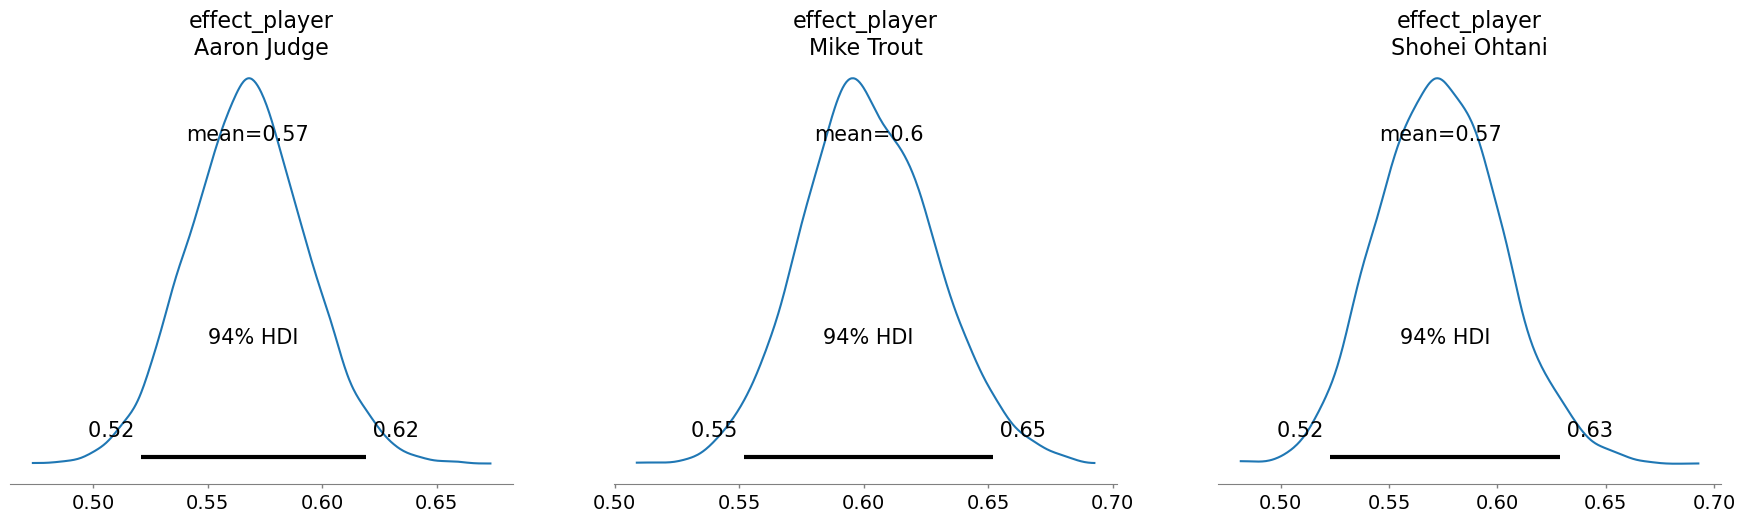

In [197]:
az.plot_posterior(idata, var_names="effect_player", coords={"player": ["Aaron Judge", "Mike Trout", "Shohei Ohtani"]});

Lastly, let's make a table of the top 10 players using our inferred SLG, which factors out the effects of season and park.  It also regularizes by the number of at bats by each particular player.

In [280]:
effect_player = az.extract(idata, var_names="effect_player")
ixs = effect_player.mean(dim="sample").argsort()[::-1].data[:10]
mean = effect_player.mean(dim="sample")[ixs].to_dataframe()
std = effect_player.std(dim="sample")[ixs].to_dataframe().rename(columns={"effect_player": "effect_stdev"})
df_top10 = pd.merge(mean, std, left_index=True, right_index=True)

df_info = df[df.Name.isin(df_top10.index)].groupby("Name").agg({"AB": "sum", "bases": "sum"})
df_info.index.rename('player', inplace=True)

results = pd.merge(df_top10, df_info, left_index=True, right_index=True)
results["calculated_slg"] = results["bases"] / results["AB"]
results

,effect_player,effect_stdev,AB,bases,calculated_slg
player,,,,,
Mike Trout,0.601877,0.026530,4240,2510,0.591981
Yordan Alvarez,0.588816,0.033549,2290,1335,0.582969
Shohei Ohtani,0.573909,0.028411,3119,1792,0.574543
Aaron Judge,0.567496,0.026037,3564,2154,0.604377
Rece Hinds,0.566557,0.104784,46,33,0.717391
Juan Soto,0.551857,0.029628,2756,1509,0.547533
Fernando Tatis Jr.,0.543783,0.033232,2009,1071,0.533101
David Ortiz,0.531881,0.038605,1583,893,0.564119
Carlos Rivero,0.528629,0.139471,7,9,1.285714


The usual suspects are all here.  Two interesting names show up.  Rece Hinds and Carlos Rivero both have excellent inferred SLGs, despite only playing a few games.  As you can see, their estimated SLG is much lower than their calculated, which demonstrates the effects of regularization in hierarchical models.

In [282]:
df[df.Name.isin(["Rece Hinds", "Carlos Rivero"])]

,Season,Name,Team,Age,AB,slg,bases
2550,2024,Rece Hinds,CIN,23,46,0.717391,33
3592,2014,Carlos Rivero,BOS,26,7,1.285714,9


Of course much more work would be required but Rece Hinds, since he's a young player, might be an interesting one to watch!

# Incorporating Age

Now that we have a working model giving reasonable results, lets incorporate our GP over age.  In the model below, the code is the same except we've added an age effect using the HSGP approximation.  Here's the summary:

- An exponentiated quadratic covariance function
- The PC prior on the lengthscale `ell`, where we think there's only a 2.5% chance that the lengthscale is less than 5 years.  We're using a PC prior because the age effect could be negligable and we want to test that.  If we use a prior that has a tighter restriction on larger lengthscale values, we risk pushing the model towards overfitting age.
- An exponential prior on the scale `eta`, where we think there's a 1% chance that the scale is larger than 0.2.  Remembering that we're setting these in the log-space, this is a pretty permissive prior, so a large age effect isn't ruled out.  The exponential distribution also has fairly heavy tails, so we could be suprised.

Since we're using the HSGP approximation, we need to set `m` and `c`, the number of basis vectors and prediction window width.  There's a helper function in PyMC that suggests values for you using the heuristics in [this paper](https://arxiv.org/abs/2004.11408).

In [294]:
x_range = [df.Age.min(), df.Age.max()]
lengthscale_range = [3, 30]
m, c = pm.gp.hsgp_approx.approx_hsgp_hyperparams(x_range, lengthscale_range, "expquad")
print("m:", m)
print("c: %0.2f" % c)

m: 55
c: 7.38


It's always OK to liberally round these numbers up (at the expense of increased compute).  The model is below:

In [295]:
# Build indices and coordinates
ix_team, team = pd.factorize(df.Team, sort=True)
ix_player, player = pd.factorize(df.Name, sort=True)
ix_year, year = pd.factorize(df.Season, sort=True)

coords = {
    "team": team,
    "player": player,
    "year": year,
}
with pm.Model(coords=coords) as model:
    # Intercept, average SLG across all data with other effects factored out
    intercept = pm.Normal("intercept", mu=-0.5, sigma=1.0)

    # Random effect for team / ballpark
    alpha, upper = 0.01, 0.1  # P(sigma_team > upper) = alpha
    sigma_team = pm.Exponential("sigma_team", lam=-np.log(alpha) / upper)
    delta_team = pm.ZeroSumNormal("delta_team", sigma=sigma_team, dims="team")

    # Random effect for player
    alpha, upper = 0.01, 0.5 # P(sigma_player > upper) = alpha
    sigma_player = pm.Exponential("sigma_player", lam=-np.log(alpha) / upper)
    delta_player = pm.ZeroSumNormal("delta_player", sigma=sigma_player, dims="player")

    # Fixed effect for season
    sigma_season = 0.1
    delta_season = pm.ZeroSumNormal("delta_season", sigma=sigma_season, dims="year")
    
    ## GP on age
    # scale prior
    alpha, upper = 0.01, 0.2 # p(eta > upper) = alpha
    eta = pm.Exponential(name="eta", lam=-np.log(alpha) / upper)

    # lengthscale prior
    input_dim = 1.0 # the PC prior for the lengthscale depends on the input dimension, defined up till input_dim=3
    alpha_ell, lower_ell = 0.025, 5.0 # p(ell < lower_ell) = alpha
    lam_ell = -np.log(alpha_ell) * (lower_ell**(0.5 * input_dim))
    alpha = input_dim / 2
    beta = 1.0 / (lam_ell ** (2 / input_dim))
    ell_inv = pm.Weibull(name="ell_inv", alpha=alpha, beta=beta)
    ell = pm.Deterministic("ell", 1 / ell_inv)

    # HSGP
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

    gp = pm.gp.HSGP(m=[75], c=8.0, cov_func=cov_func)
    f = gp.prior("f", X=df.Age.values[:, None])
    
    # Linear predictor
    bases_exp = pm.Deterministic(
        "bases_exp", 
        pm.math.exp(
            np.log(df.AB.values) + 
            intercept + 
            delta_player[ix_player] +
            delta_season[ix_year] +
            delta_team[ix_team] +
            f
        ), 
    )
    
    ## Likelihood, negative binomial with overdispersion parameter alpha
    # PC prior on alpha
    epsilon, lower = 0.01, 10 # P(alpha < lower) = epsilon
    def pc_negbinom_kld_distance_inv(alpha):
        return pt.sqrt(2.0 * (pt.log(1.0 / alpha) - pt.digamma(1.0 / alpha)))
    lam = -np.log(epsilon) / pc_negbinom_kld_distance_inv(1.0 / lower)
    alpha = pm.Deterministic("alpha", 1 / pm.Weibull("alpha_", alpha=0.5, beta=1.0 / lam**2))
    pm.NegativeBinomial("bases", mu=bases_exp, alpha=alpha, observed=df.bases.values)

    effect_player = pm.Deterministic("effect_player", pt.exp(intercept + delta_player), dims="player")

In [296]:
compiled_model = nutpie.compile_pymc_model(model, backend="jax")
idata = nutpie.sample(
    compiled_model,
    blocking=True,
    target_accept=0.8,
    tune=300,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,140,0.11,31
,1300,11,0.08,63
,1300,163,0.10,4
,1300,50,0.10,31
,1300,12,0.09,63
,1300,0,0.08,63


We have problems!  First of all, that's way too many divergences.  The first fix I would try is the easiest.  Switching covariances to not use the exponentiated quadratic, and to use a different member of the Matern family.

# Issues with the exponentiated quadratic as a default choice

The exponential quadratic is a great kernel for pedogogical reasons.  It has a simple and easy to rationalize form.  However in practice, particularly in PPL settings like this, **it's not a great choice as a default kernel**.  This choice often causes problems.  

The reason is because **the exponentiated quadratic kernel is too smooth**.  Below is a picture comparing samples drawn from an exponentiated quadratic and those from a Matern $\frac{5}{2}$ and a Matern $\frac{3}{2}$ (the other two that work with the HSGP approximation out of the box).  That smoothness acts as a very strong constraint that makes it difficult to fit models, especially when you're using MCMC.  The other Matern ones relax this smoothness constraint.  In my opinion **when using MCMC, the best default kernel to start with is the `Matern52`**.  It's smooth, but not too smooth.

A fact to keep in mind, is that the expected value, or mean of the GP is always going to be smoother than the individual samples (I found this factoid [here](https://dansblog.netlify.app/posts/2021-11-03-yes-but-what-is-a-gaussian-process-or-once-twice-three-times-a-definition-or-a-descent-into-madness/yes-but-what-is-a-gaussian-process-or-once-twice-three-times-a-definition-or-a-descent-into-madness)).  This makes sense because that's what averages do.  Why this is important, is because you're probably used to looking at plots of the means of GP, not individual draws from the posterior.  This might give you a bias towards thinking the functions you're modeling are smoother than they actually are.  

For example, since they are from the prior, the mean of these samples would end up as a flat line at zero, which is quite a bit smoother than the individual draws. 

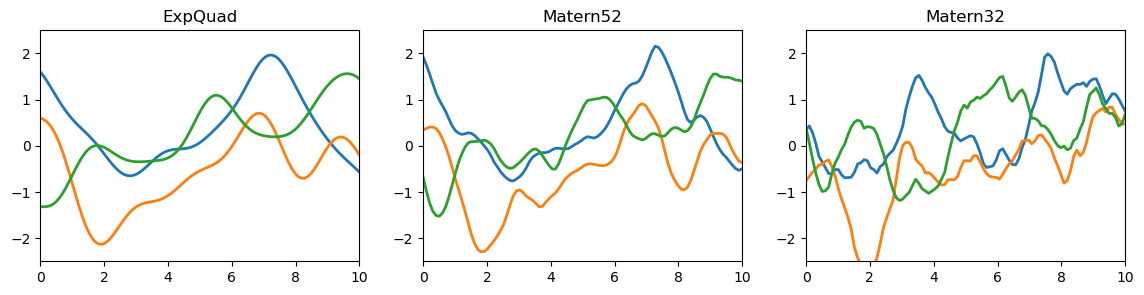

In [316]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3));
x = np.linspace(0, 10, 100)

seed = 9323
rng = np.random.default_rng(seed)
K = pm.gp.cov.ExpQuad(1, ls=1)(x[:, None]).eval()
s = pm.draw(pm.MvNormal.dist(mu=np.zeros(100), cov=K), 3, random_seed=rng).T
axs[0].plot(x, s, lw=2);
axs[0].set_title("ExpQuad")

rng = np.random.default_rng(seed)
K = pm.gp.cov.Matern52(1, ls=1)(x[:, None]).eval()
s = pm.draw(pm.MvNormal.dist(mu=np.zeros(100), cov=K), 3, random_seed=rng).T
axs[1].plot(x, s, lw=2);
axs[1].set_title("Matern52")

rng = np.random.default_rng(seed)
K = pm.gp.cov.Matern32(1, ls=1)(x[:, None]).eval()
s = pm.draw(pm.MvNormal.dist(mu=np.zeros(100), cov=K), 3, random_seed=rng).T
axs[2].plot(x, s, lw=2);
axs[2].set_title("Matern32")

for ax in axs:
    ax.set_xlim([0, 10])
    ax.set_ylim([-2.5, 2.5]);

Let's run the same model, but make two changes.

1. Swap kernels.  Use a `Matern52` instead of `ExpQuad`
2. Set `parametrize="centered"`.  The default for HSGP is `"noncentered"`.  When the values are strongly informed by the data, the centered parameterization usually samples better, even though both are equivalent.  You've probably seen how the non-centered vs. centered parameterization effects normal hierarchical models.  The exact same thing happens here.  Since we were using the non-centered parameterization, the divergences are a clue that the age effect is possibly quite strongly influenced by the data and we should switch parameterizations.

With these two changes, the model samples without divergences and the R-hat values are all near one.  We didn't even need to increase the `target_accept`.  

Note that these adjustments had to be made **after** we chose a good prior for the lengthscale, the PC prior!  Since the effect turns out to be strongly influenced by the data, we could consider using more informative priors.

In [396]:
x_range = [df.Age.min(), df.Age.max()]
lengthscale_range = [3, 30]
m, c = pm.gp.hsgp_approx.approx_hsgp_hyperparams(x_range, lengthscale_range, "matern52")
print("m:", m)
print("c: %0.2f" % c)

m: 108
c: 9.46


In [391]:
# Build indices and coordinates
ix_team, team = pd.factorize(df.Team, sort=True)
ix_player, player = pd.factorize(df.Name, sort=True)
ix_year, year = pd.factorize(df.Season, sort=True)
ix_age, age = pd.factorize(df.Age, sort=True)


coords = {
    "team": team,
    "player": player,
    "year": year,
    "age": age,
}
with pm.Model(coords=coords) as model:
    # Intercept, average SLG across all data with other effects factored out
    intercept = pm.Normal("intercept", mu=-0.5, sigma=1.0)

    # Random effect for team / ballpark
    alpha, upper = 0.01, 0.1  # P(sigma_team > upper) = alpha
    sigma_team = pm.Exponential("sigma_team", lam=-np.log(alpha) / upper)
    delta_team = pm.ZeroSumNormal("delta_team", sigma=sigma_team, dims="team")

    # Random effect for player
    alpha, upper = 0.01, 0.5 # P(sigma_player > upper) = alpha
    sigma_player = pm.Exponential("sigma_player", lam=-np.log(alpha) / upper)
    delta_player = pm.ZeroSumNormal("delta_player", sigma=sigma_player, dims="player")

    # Fixed effect for season
    sigma_season = 0.1
    delta_season = pm.ZeroSumNormal("delta_season", sigma=sigma_season, dims="year")
    
    ## GP on age
    # scale prior
    alpha, upper = 0.01, 0.2 # p(eta > upper) = alpha
    eta = pm.Exponential(name="eta", lam=-np.log(alpha) / upper)

    # lengthscale prior
    input_dim = 1.0 # the PC prior for the lengthscale depends on the input dimension, defined up till input_dim=3
    alpha_ell, lower_ell = 0.025, 5.0 # p(ell < lower_ell) = alpha
    lam_ell = -np.log(alpha_ell) * (lower_ell**(0.5 * input_dim))
    alpha = input_dim / 2
    beta = 1.0 / (lam_ell ** (2 / input_dim))
    ell_inv = pm.Weibull(name="ell_inv", alpha=alpha, beta=beta)
    ell = pm.Deterministic("ell", 1 / ell_inv)

    # HSGP
    cov_func = eta**2 * pm.gp.cov.Matern52(1, ls=ell)
    gp = pm.gp.HSGP(m=[125], c=9.5, cov_func=cov_func, drop_first=False, parametrization="centered")
    X = df.Age.values[:, None]
    delta_age = gp.prior("delta_age", X=X)
    
    # Linear predictor
    bases_exp = pm.Deterministic(
        "bases_exp", 
        pm.math.exp(
            np.log(df.AB.values) + 
            intercept + 
            delta_player[ix_player] +
            delta_season[ix_year] +
            delta_team[ix_team] +
            delta_age
        ), 
    )
    
    ## Likelihood, negative binomial with overdispersion parameter alpha
    # PC prior on alpha
    epsilon, lower = 0.01, 10 # P(alpha < lower) = epsilon
    def pc_negbinom_kld_distance_inv(alpha):
        return pt.sqrt(2.0 * (pt.log(1.0 / alpha) - pt.digamma(1.0 / alpha)))
    lam = -np.log(epsilon) / pc_negbinom_kld_distance_inv(1.0 / lower)
    alpha = pm.Deterministic("alpha", 1 / pm.Weibull("alpha_", alpha=0.5, beta=1.0 / lam**2))
    pm.NegativeBinomial("bases", mu=bases_exp, alpha=alpha, observed=df.bases.values)

    effect_player = pm.Deterministic("effect_player", pt.exp(intercept + delta_player), dims="player")
    effect_age = pm.Deterministic("effect_age", pt.exp(intercept + delta_age))

In [392]:
compiled_model = nutpie.compile_pymc_model(model, backend="jax")
idata = nutpie.sample(
    compiled_model,
    blocking=True,
    target_accept=0.8,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.08,63
,1300,0,0.10,63
,1300,0,0.08,63
,1300,0,0.09,63
,1300,0,0.07,63
,1300,1,0.10,63


In [393]:
az.summary(idata, var_names=["sigma_team", "sigma_player", "delta_team", "delta_player", "alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_team,0.023,0.005,0.014,0.033,0.000,0.000,2232.0,3009.0,1.0
sigma_player,0.309,0.008,0.293,0.324,0.000,0.000,1176.0,2014.0,1.0
delta_team[ARI],0.019,0.014,-0.007,0.047,0.000,0.000,4997.0,4100.0,1.0
delta_team[ATL],-0.001,0.014,-0.028,0.024,0.000,0.000,5559.0,3580.0,1.0
delta_team[BAL],0.019,0.015,-0.009,0.048,0.000,0.000,4611.0,4311.0,1.0
...,...,...,...,...,...,...,...,...,...
delta_player[Zack Wheeler],-0.403,0.127,-0.637,-0.159,0.001,0.001,10351.0,2811.0,1.0
delta_player[Zeke Spruill],0.025,0.285,-0.501,0.572,0.003,0.004,11801.0,3910.0,1.0
delta_player[Zelous Wheeler],-0.054,0.199,-0.421,0.312,0.002,0.003,12237.0,3803.0,1.0
delta_player[Zoilo Almonte],-0.174,0.221,-0.620,0.225,0.004,0.003,2851.0,3948.0,1.0


And here's our result!

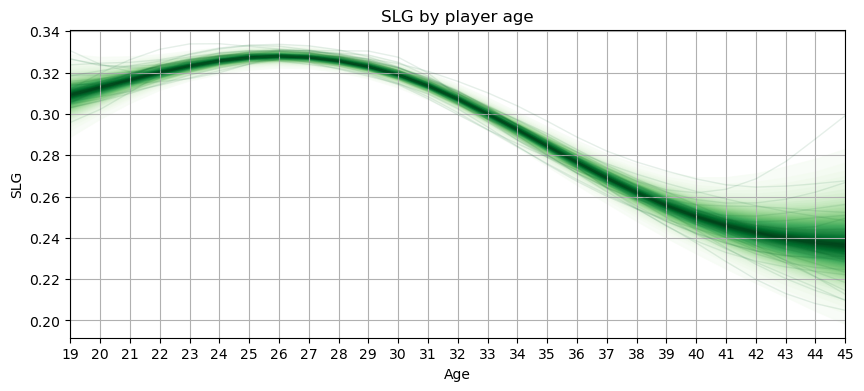

In [395]:
x = df.Age.values
x, ix = np.unique(x, return_index=True)

effect_age = az.extract(idata, var_names="effect_age")
effect_age = effect_age.isel(effect_age_dim_0=ix)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
pm.gp.util.plot_gp_dist(x=x, samples=effect_age.T, ax=ax, palette=plt.cm.Greens);
ax.set_xticks(x);
ax.set_xlim([x.min(), x.max()]);
ax.set_xlabel("Age");
ax.set_ylabel("SLG");
ax.set_title("SLG by player age");
ax.grid(True);
#ax.set_ylim([0.35, 0.40]);

This is where the someone common (for baseball) knowledge that players tend to peak at age 26 comes from.

# Conclusion

- An alternative way to motivate and introduce the concept of a Gaussian process is as an extension of a normal hierarchical model.
- Fitting GPs using MCMC can be particularly tricky.
- We covered the root causes of common identifiability issues at:
   - small lengthscales
   - large lengthscales
   - between $\eta$ and $\ell$
   - from "small N", depending on what you mean by N.  
- The fixes generally involve using more informative priors in particular ways to help resolve the identifiability issues.
- Then we built a non-trivial model for SLG, the number of bases hit per at bat.
- Even though we started with a good lengthscale prior, the PC prior, we still had issues sampling.
- We solved the problem using two easy, but often overlooked(!) fixes:
  - Use the `Matern52` instead of the `ExpQuad`, because the `ExpQuad` is too smooth.
  - Use the centered parameterization instead of the default non-centered.

We hope this example can serve as a guide that'll help you build GP models and avoid some frustration.